# Creating a model and training it for generating and clustering music

In [36]:
#TODO: Create models: VAE, WAE, U-NET
#Save model weights
#Evaluate in this file?

In [37]:
#libraries
import deeplay as dl
import deeptrack as dt
import torch
import os
from PIL import Image, ImageOps
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2gray

In [38]:
#Preprocess data
data_dir = os.path.expanduser("./trainImagesSmall")

# Load image files using ImageFolder
trainFiles = dt.sources.ImageFolder(root=data_dir)
print(f"Number of train images: {len(trainFiles)}")

Number of train images: 1000


In [39]:
for i in trainFiles:
    img = i['label_name']
    print(img)
    print(i)
    break

000002_1.jpg
SourceItem({'path': './trainImagesSmall\\000002_1.jpg', 'label': 850, 'label_name': '000002_1.jpg'})


In [40]:
#Create image pipeline
class CropWidth:
    def __init__(self, target_width):
        self.target_width = target_width

    def __call__(self, x: torch.Tensor):
        # assuming input shape [C, H, W]
        return x[..., :self.target_width]
    
image_pip = (dt.LoadImage(trainFiles.path) >> dt.NormalizeMinMax()
             >> dt.MoveAxis(2, 0) >> dt.pytorch.ToTensor(dtype=torch.float) >> CropWidth(512))

In [41]:
img_tensor = image_pip(trainFiles.path[0])
print(f"The size of each image is: {img_tensor.shape}")

The size of each image is: torch.Size([1, 512, 512])


In [42]:
#VAE
from deeplay import AdamW
import torch
#torch.cuda.empty_cache()
#Dont use reduction="sum" gradients becomes giant and memory issues are made worse. //BD
vae = dl.VariationalAutoEncoder(input_size=(512,512),
    latent_dim=2, channels=[32, 64, 128, 256],
    reconstruction_loss=torch.nn.BCELoss(reduction="mean"), beta=1
).create()
"""
for i in range(len(vae.encoder.blocks)):
    vae.encoder.blocks[i].layer.kernel_size = (3,30)
    vae.decoder.blocks[i].layer.kernel_size = (3,30)
"""
print(vae)

VariationalAutoEncoder(
  (encoder): ConvolutionalEncoder2d(
    (blocks): LayerList(
      (0): Conv2dBlock(
        (layer): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (1): Conv2dBlock(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (2): Conv2dBlock(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (3): Conv2dBlock(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (4): Conv2dBlock(
        (pool): MaxPool2d(kernel_size=2

In [43]:
train_dataset = dt.pytorch.Dataset(image_pip & image_pip, inputs=trainFiles)
train_loader = dl.DataLoader(train_dataset, batch_size=4, shuffle=True)

In [44]:
"""
import dataset
train_dataset = dataset.Dataset(image_pip & image_pip, inputs=trainFiles)
print(train_dataset)
train_loader = dl.DataLoader(train_dataset, batch_size=4, shuffle=True)
"""

'\nimport dataset\ntrain_dataset = dataset.Dataset(image_pip & image_pip, inputs=trainFiles)\nprint(train_dataset)\ntrain_loader = dl.DataLoader(train_dataset, batch_size=4, shuffle=True)\n'

In [45]:
"""
for image, image2 in train_loader:
    print(image)
    break
    """

'\nfor image, image2 in train_loader:\n    print(image)\n    break\n    '

In [46]:
vae_trainer = dl.Trainer(max_epochs=2, accelerator="auto")
vae_trainer.fit(vae, train_loader)


  | Name                | Type                   | Params | Mode 
-----------------------------------------------------------------------
0 | encoder             | ConvolutionalEncoder2d | 977 K  | train
1 | fc_mu               | Linear                 | 524 K  | train
2 | fc_var              | Linear                 | 524 K  | train
3 | fc_dec              | Linear                 | 786 K  | train
4 | decoder             | ConvolutionalDecoder2d | 1.3 M  | train
5 | reconstruction_loss | BCELoss                | 0      | train
6 | train_metrics       | MetricCollection       | 0      | train
7 | val_metrics         | MetricCollection       | 0      | train
8 | test_metrics        | MetricCollection       | 0      | train
9 | optimizer           | Adam                   | 0      | train
-----------------------------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.557    Total estimated model params size (MB)

Training: |          | 0/? [00:00<?, ?it/s]

In [ ]:
def plot_training(epochs, train_losses):
    """Plot the training loss."""
    plt.plot(range(epochs), train_losses, label="Training Loss")
    plt.xlabel("Epoch")
    plt.xlim([0, epochs - 1])
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

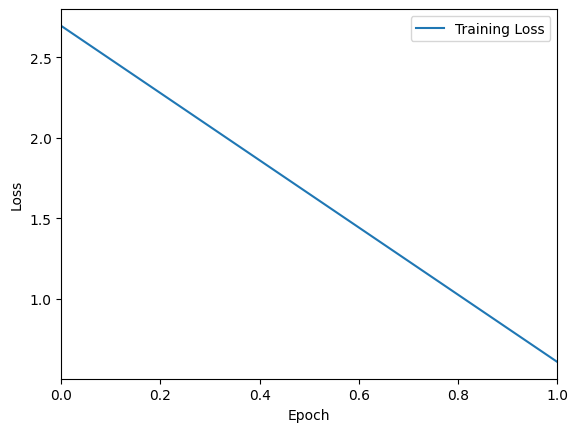

{'train_rec_loss_epoch': {'value': [0.6163225173950195, 0.601482093334198], 'epoch': [0, 1], 'step': [250, 500]}, 'train_KL_epoch': {'value': [2.079847812652588, 0.005861253943294287], 'epoch': [0, 1], 'step': [250, 500]}, 'train_total_loss_epoch': {'value': [2.6961700916290283, 0.6073433756828308], 'epoch': [0, 1], 'step': [250, 500]}}


In [ ]:
"""NOTE: We can also plot the KL-loss and rec loss separately, to see all alternatives, use the following line:
print(vae_trainer.history.history)"""

train_losses = vae_trainer.history.history["train_total_loss_epoch"]["value"]
epochs = len(train_losses)
plot_training(epochs, train_losses)

In [47]:
#WAE, let us just focus on the VAE for now, later we can use this code
wae = dl.WassersteinAutoEncoder(
    channels=[32, 64, 128], latent_dim=20,
    reconstruction_loss=torch.nn.MSELoss(reduction="mean"),
).create()

#print(wae)